XSuperlet Python Examples
===

Start by importing modules and loading a light curve.

In [18]:
import numpy as np
from pylag import LightCurve, Periodogram
from matplotlib import pyplot as plt

from xsuperlet.sim_light_curve import LightCurveSampler
from xsuperlet.superlet_transform import SuperletTransform

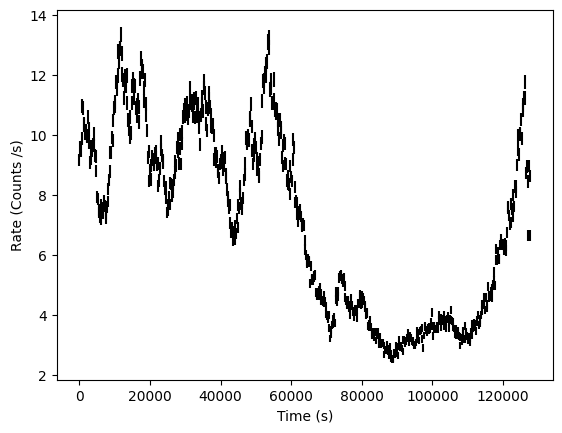

In [2]:
# Load sample light curve
lc = LightCurve("SampleLightCurves/2016_tbin10_en300-10000.fits").rebin(200)
lc.zero_time()

plt.errorbar(lc.time, lc.rate, yerr=lc.error, linestyle="None", markersize=2, color="k")
plt.xlabel("Time (s)")
plt.ylabel("Rate (Counts /s)")
plt.show()

Light Curve Simulation Example
===

XSuperlet contains a light curve simulation class loosely based on https://github.com/lena-lin/emmanoulopoulos, with Kernel density estimation (KDE) for PDF fitting.

Here we initialise the light curve sampler and verify we are happy with the PDF fit. In this example we are using the Gaussian KDE fit. This is a non-parametric model that works well across a range of light curve count rate PDFs.

We then run a single simulation using the Emmanoulopoulos method.

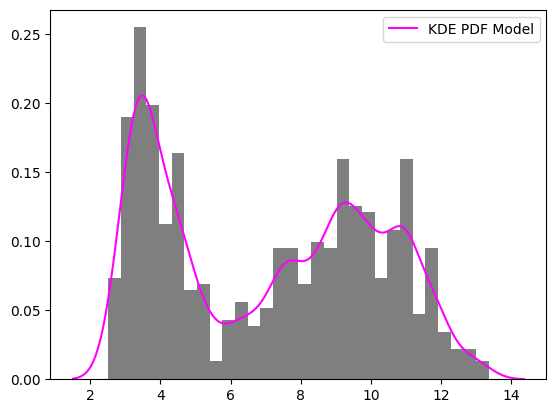

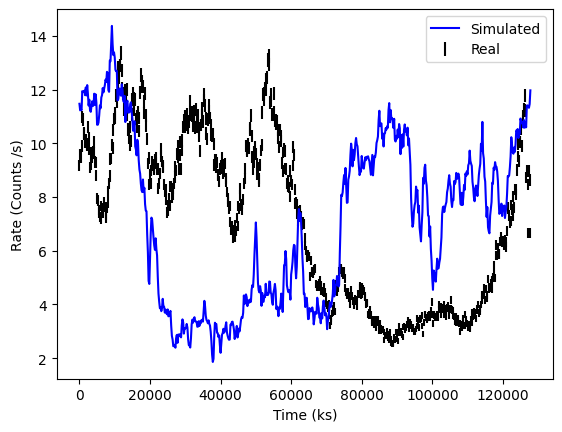

In [16]:
# Initialise sampler
sampler = LightCurveSampler(real_lc=lc, kde=True)

# We may wish to refit/verify the PDF model
sampler.fit_pdf(True)

# Simulate one light curve by the method of Emmanoulopoulos et al. (2013)
# This may take some time
sim_lc = sampler.em_sample()

plt.errorbar(lc.time, lc.rate, yerr=lc.error, linestyle="None", markersize=2, color="k", label="Real")
plt.plot(sim_lc.time, sim_lc.rate, markersize=2, color="b", label="Simulated")
plt.xlabel("Time (ks)")
plt.ylabel("Rate (Counts /s)")
plt.legend()
plt.show()

We can verify the properties of our simulated light curve vs the real light curve by plotting their PSD and PDFs.

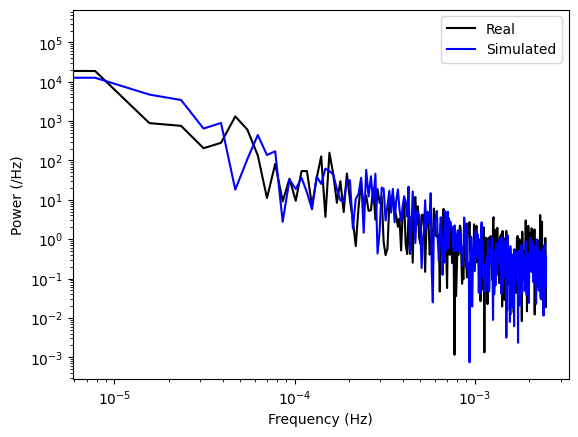

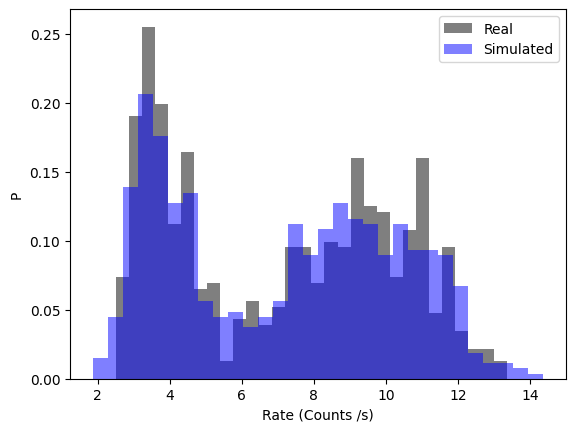

In [22]:
# PSD
real_psd = Periodogram(lc)
sim_psd = Periodogram(sim_lc)
plt.loglog(real_psd.freq, real_psd.periodogram, color="k", label="Real")
plt.loglog(sim_psd.freq, sim_psd.periodogram, color="b", label="Simulated")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (/Hz)")
plt.legend()
plt.show()

# PDF
plt.hist(lc.rate, bins=30, color="k", alpha=0.5, density=True, label="Real")
plt.hist(sim_lc.rate, bins=30, color="b", alpha=0.5, density=True, label="Simulated")
plt.xlabel("Rate (Counts /s)")
plt.ylabel("P")
plt.legend()
plt.show()

If the PDF is not a close enough fit, try changing the width of the Gaussians in the KDE model `sampler.kde_width=0.x`, or using a different kernel.

The XSuperlet program (`xsuperlet_terminal.py`) contains functions to simulate 1000s of light curves in parallel if required.

You may choose to use a parametric model containing gamma and/or lognormal and/or other components. This is not recommended. If you do this you should set `kde` to `false` and check `LightCurveSampler.__pdf_model()` to tweak the model to fit your data. By default, the example given in *Emmanoulopoulos et al. (2013)* is the non-kde model, this likely will not fit your PDF without modification.

Superlet Transform Example
===

XSuperlet contains a superlet/wavelet transform class based on https://github.com/TransylvanianInstituteOfNeuroscience/Superlets/.

To calculate the wavelet (CWT) or superlet (SLT) transforms of our light curve, we first need the sample rate and a grid of frequencies to calculate the transform over.

We can then proceed to create a `SuperletTransform` object and calculate the transform.

In [23]:
# Calculate sample rate, assuming even spacing
# Note that an integer sample rate is required, so switch from seconds to megaseconds
sample_rate = int((1 / int((lc.time[1] - lc.time[0])) * 1E+6))
print(f"{sample_rate} Hz")

# Define frequency grid
f_grid = np.logspace(np.log10(20), np.log10(200), 1000)

# Calculate the SLT for our real light curve
slt = SuperletTransform(times=lc.time * 1E-6, signal=lc.rate, f_s=sample_rate, freqs=f_grid, c_1=3, orders=[2, 6])
slt.calculate_transform()
transform = slt.transform

5000 Hz


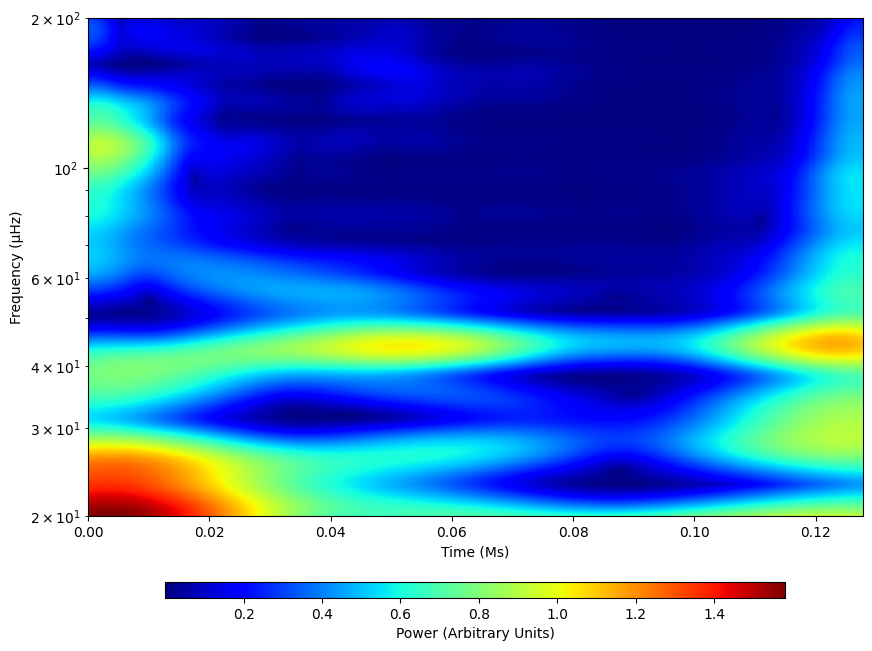

In [24]:
# Plot with the built-in method
slt.plot_scalogram()

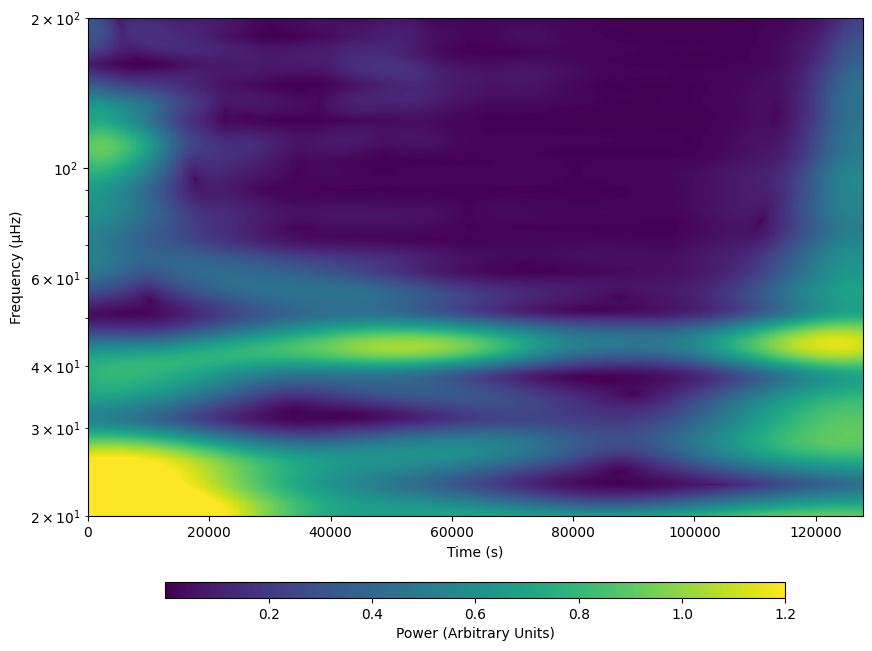

In [25]:
# Plot with more control (This is the plot_scalogram() method using our local variables)

# Find edges for pcolormesh
d_t = np.diff(lc.time).mean()
time_edges = np.concatenate([[lc.time[0]  - d_t / 2], lc.time[:-1] + d_t / 2, [lc.time[-1] + d_t / 2]])
freq_edges = np.geomspace(f_grid[0], f_grid[-1], len(f_grid) + 1)

# Create figure and scalogram
fig, ax = plt.subplots(figsize=(10, 7), label="Wavelet Scalogram")
scalogram = ax.pcolormesh(*np.meshgrid(time_edges, freq_edges), transform, cmap="viridis", shading="flat", vmax=1.2)

# Axes limits and labels
limits = (float(lc.time[0]), float(lc.time[-1]), float(f_grid[0]), float(f_grid[-1]))
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.set_yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (μHz)")

# Colour bar
fig.colorbar(scalogram, label="Power (Arbitrary Units)", orientation="horizontal", ax=ax, aspect=40, shrink=0.8, pad=0.1)
plt.subplots_adjust(top=0.95, bottom=0.001)
plt.show(block=False)

# Deal with tick formatting
y_min, y_max = ax.get_ylim()
visible_ticks = [tick for tick in ax.get_yticks() if y_min <= tick <= y_max]
formatted_ticks = [int(tick) for tick in visible_ticks]
ax.set_yticks(formatted_ticks, [str(tick) for tick in formatted_ticks])

The XSuperlet program contains multiple additional functions related to wavelet analysis such as the ability to calculate the cone of influence (COI), measure the FWHM of frequency peaks, and trace changes in frequency over time.